# Supervised (LDA-like) projection using the SEF

### Load the data

First, we have to load a dataset! Let's use keras to load the well-known MNIST dataset.

In [2]:
import numpy as np
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape and normalize the data
x_train = x_train.reshape((x_train.shape[0], -1)) / 255.0
x_test = x_test.reshape((x_test.shape[0], -1)) / 255.0

x_train, x_test = np.float32(x_train), np.float32(x_test)

### Learn a projection using SEF

First, we have to create a linear SEF object. Note that we have to supply the number of input dimensions, as well as the target dimensionality. We can also specify the learning rate and the regularizer weight in the class constructor (usually the default values work just fine).


In [3]:
import sef_dr

linear_sef = sef_dr.LinearSEF(input_dimensionality=x_train.shape[1], output_dimensionality=9)

# Move the model to GPU (comment this out, if a cuda-enabled GPU is not availabe)
linear_sef.cuda()

Then, we fit the projection. We have to supply the type of the target similarity matrix (or a function that creates the target similarity matrix on-the-fly).

In [4]:
loss = linear_sef.fit(data=x_train[:5000], target_labels=y_train[:5000], target='supervised', epochs=100, regularizer_weight=0.001, learning_rate=0.0001, batch_size=128,)

Let's examine the loss function:

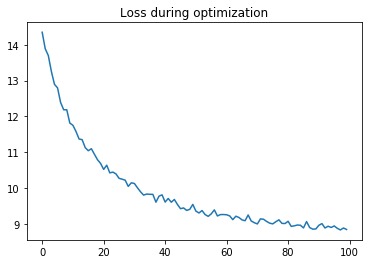

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

plt.plot(np.arange(loss.shape[0]), loss)
plt.title('Loss during optimization')
plt.show()

The loss is practically the same after the 20th iteration, so a solution has been found. Let's evaluate it!
First, transform the data:

In [6]:
# Tranform the data
train_data = linear_sef.transform(x_train)
test_data = linear_sef.transform(x_test)

Then, use an SVM to evaluate the solution:

In [8]:
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)
    
parameters = {'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]}
model = svm.SVC(max_iter=10000)
clf = GridSearchCV(model, parameters, cv=3)
clf.fit(train_data[:5000], y_train[:5000])

print("Linear SEF Αccuracy = ", clf.score(test_data, y_test) * 100, "%")

Linear SEF Αccuracy =  88.79 %


### Compare to LDA

The solutions seem good enough, but let's compare it to the regular LDA method!

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Fit the LDA projection
lda = LinearDiscriminantAnalysis(n_components=9)
lda.fit(x_train[:5000, :], y_train[:5000])

# Tranform the data
train_data = lda.transform(x_train)
test_data = lda.transform(x_test)

# Scale the data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)
    
parameters = {'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]}
model = svm.SVC(max_iter=10000)
clf = GridSearchCV(model, parameters, cv=3)
clf.fit(train_data[:5000], y_train[:5000])

print ("SVM Αccuracy = ", clf.score(test_data, y_test) * 100, "%")

SVM Αccuracy =  85.47 %
